In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# produced by the notebook "classify all features extracted from all the runs"
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
# copied from BAM
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"
EXPERIMENT_METRICS_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl"


In [3]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [4]:
get_percolator_run_mapping(MAPPING_FILE_NAME)

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [5]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)
sequences_with_species_df.drop(['intensity'], axis=1, inplace=True)

In [6]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [7]:
sequences_with_species_df.sample(2)

,sequence,charge,file_idx,classed_as,run_name,batch,human
5669,GVEITGFPEAQALGLEVFHAGTALK,3,8,target,190719_Hela_Ecoli_1to1_10,1to1,True
816,VLAALAASSGSSSASSSSAPVAASSGQATTQSK,3,4,target,190719_Hela_Ecoli_1to3_05,1to3,True


In [8]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric valuesa
    d = row.attributes
    if (d is not None):
        # check whether any of the values are None
        all_not_none = True
        for k,v in d.items(): 
            if d[k] is None:
                all_not_none = False
                break
        # add the attributes to the collection
        if all_not_none == True:
            l = []
            l.append(row.sequence)
            l.append(row.charge)
            l.append(row.file_idx)
            l += [d[key] for key in sorted(d)]
            attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [9]:
attributes_as_extracted_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex'],
      dtype='object')

In [10]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])

In [11]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [12]:
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity)

In [13]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'monoisotopic_mz', 'rt_apex', 'scan_apex', 'classed_as', 'run_name',
       'batch', 'human', 'log_intensity'],
      dtype='object')

In [14]:
# find the experiment-wide means and std devs
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','number_of_runs_for_sequence'])


In [15]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [16]:
len(sequences_df[sequences_df.human == False])

1415

In [17]:
sequences_df[(sequences_df.number_of_runs_for_sequence > 15) & (sequences_df.human == False)].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
6387,ANGAEIDDGAINGIK,2,17,1,16546,2,"[(22346, True, [(729.363025667686, 587.0, 4701...",729.365750,498.615997,597.615626,...,1to3,False,14.014195,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
3880,SIGNTVSPQDVMNK,2,10,1,6712,2,"[(20018, True, [(745.3695602348796, 564.0, 479...",745.369561,509.077006,571.015714,...,1to1,False,12.712527,12.607739,0.328561,507.589761,3.296366,570.719881,2.579629,20
1278,SGHPGAPMGMADIAEVLWR,3,3,0,4090,0,"[(4090, False, [(665.6575359995458, 807.0, 912...",665.657536,981.261664,814.083406,...,1to3,False,11.997885,10.574902,1.233655,989.143780,6.047808,813.517978,4.758908,20
7153,LGASVVGFSDSANTSLGK,2,19,0,1180,0,"[(1180, False, [(855.4368858245128, 333.0, 610...",855.439713,649.195886,349.005029,...,1to1,False,10.204571,11.376942,0.533513,648.288143,3.398484,349.981325,3.290334,20
6108,NNMTIGIGAGQMSR,2,17,0,835,0,"[(835, False, [(725.3494732889349, 594.0, 5201...",725.351629,553.094939,601.792747,...,1to3,False,9.705632,9.232006,0.691001,555.208554,3.560066,601.805757,5.359691,20
5620,AQSSGILAEEIVPVVLK,2,15,0,431,0,"[(431, False, [(877.0086111742141, 317.0, 9196...",877.008611,982.999005,335.489646,...,1to1,False,8.751544,8.975705,1.045548,976.711222,4.167889,334.873549,6.549507,20
204,HNVPAGSESHFK,2,0,0,416,0,"[(416, False, [(655.3163706508363, 717.0, 1676...",655.318114,186.141443,728.331693,...,1to3,False,8.700440,9.738975,0.931717,191.671011,8.358352,725.199115,5.174503,20
1412,GLSVLMLEAQDLACATSSASSK,3,3,0,368,0,"[(368, False, [(747.0358182961272, 566.0, 9426...",747.037555,1014.387990,569.401786,...,1to3,False,8.523562,8.792851,1.154509,1018.328409,3.107770,578.401042,22.265528,19
3607,LMEEEGILAGISSGAAVAAALK,2,10,0,219,0,"[(219, False, [(1051.0615980343778, 84.0, 9736...",1051.064135,1040.863379,103.501623,...,1to1,False,7.774787,10.798798,1.176788,1052.773581,4.269645,101.937845,7.803000,20
6677,VHVHVEEGSPK,2,18,0,147,0,"[(147, False, [(609.3140732998743, 719.0, 1992...",609.316747,210.862534,744.919059,...,1to1,False,7.199672,10.733017,1.692838,209.615629,2.338391,752.056649,12.562522,20


In [18]:
sequences_df.classed_as.unique()

array(['target'], dtype=object)

In [25]:
selected_sequence = 'ANGAEIDDGAINGIK'
selected_sequence_charge = 2

In [26]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()

In [27]:
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

In [28]:
selected_sequence_df

,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,monoisotopic_mz,rt_apex,scan_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
4240,ANGAEIDDGAINGIK,2,11,1,5075,2,"[(3762, True, [(729.3630458664338, 593.0, 4749...",729.364932,503.835235,602.471091,...,1to1,False,12.309192,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
6028,ANGAEIDDGAINGIK,2,16,1,12807,2,"[(8832, True, [(729.3630185287719, 592.0, 4760...",729.365694,504.274122,600.705969,...,1to1,False,13.644645,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
2470,ANGAEIDDGAINGIK,2,6,1,10752,2,"[(11367, True, [(729.3630246300237, 591.0, 475...",729.365155,505.429190,600.858187,...,1to1,False,13.392317,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
5664,ANGAEIDDGAINGIK,2,15,1,12587,2,"[(7846, True, [(729.363051610922, 591.0, 4761....",729.364834,504.184367,599.998982,...,1to1,False,13.619647,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
6751,ANGAEIDDGAINGIK,2,18,1,11673,2,"[(13346, True, [(729.3630544404122, 588.0, 476...",729.365372,504.621523,598.301610,...,1to1,False,13.510888,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
7099,ANGAEIDDGAINGIK,2,19,1,11458,2,"[(7663, True, [(729.3630420301563, 587.0, 4721...",729.365926,502.426480,597.029912,...,1to1,False,13.484068,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
664,ANGAEIDDGAINGIK,2,1,1,12943,2,"[(8676, True, [(729.3630610227654, 586.0, 4735...",729.365728,502.935703,596.330516,...,1to1,False,13.659884,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
3872,ANGAEIDDGAINGIK,2,10,1,14613,2,"[(5534, True, [(729.3630516124127, 588.0, 4736...",729.366202,501.636047,598.022657,...,1to1,False,13.834965,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
1015,ANGAEIDDGAINGIK,2,2,0,6145,0,"[(6145, False, [(729.3630114892787, 591.0, 472...",729.365812,502.450098,599.139867,...,1to1,False,12.585197,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20
3176,ANGAEIDDGAINGIK,2,8,1,8197,1,"[(11694, True, [(729.3630645783207, 590.0, 472...",729.365869,502.595238,600.374308,...,1to1,False,13.000880,13.463037,0.418322,500.263051,3.322235,599.402976,2.154243,20


In [31]:
selected_sequence_df.to_pickle('/Users/darylwilding-mcbride/Downloads/sequence-{}-charge-{}-df.pkl'.format(sequence, charge))

In [29]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

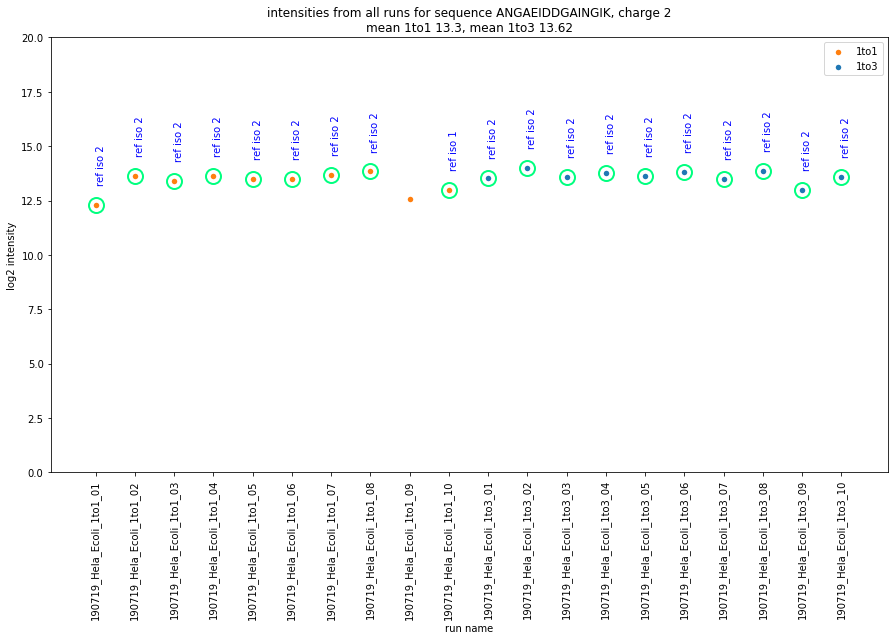

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, np.log2(selected_sequence_1to1_df.intensity), marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1')
ax1.scatter(selected_sequence_1to3_df.run_name, np.log2(selected_sequence_1to3_df.intensity), marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to1.run_name, np.log2(adj_sat_1to1.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to3.run_name, np.log2(adj_sat_1to3.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()